# SAEval

In [6]:
import pandas  as pd

data = pd.read_json('tasks/ioi/scores.json')

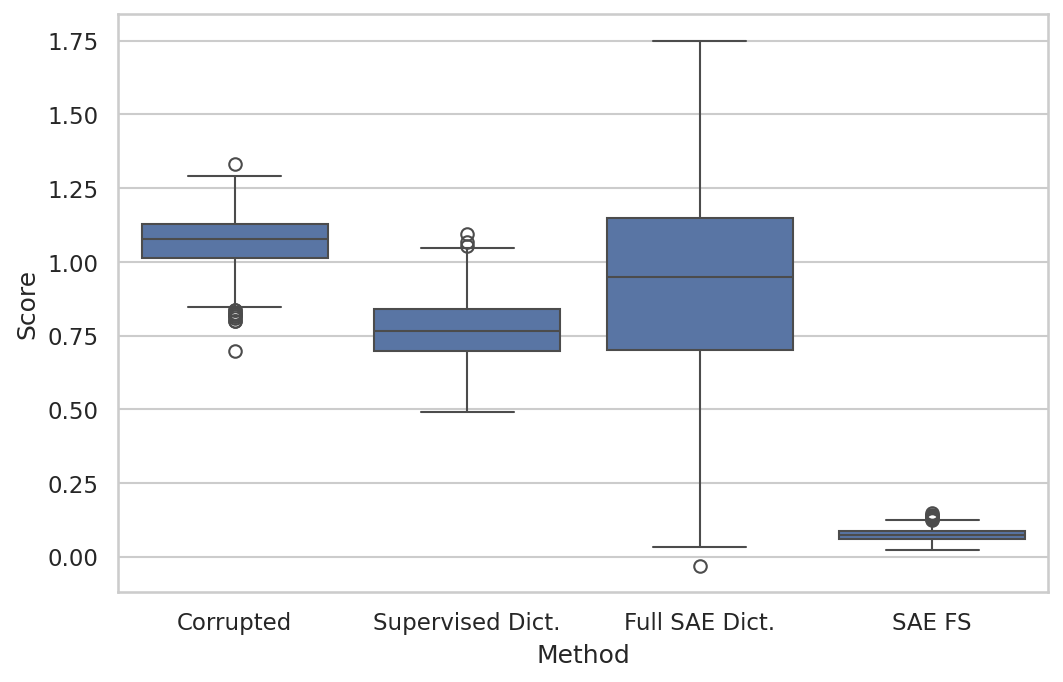

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt
scores = data[['patch_corr_score', 'patch_supervised_score', 'patch_all_sae_score', 'patch_sae_fs_score']]
scores.columns = ['Corrupted', 'Supervised Dict.', 'Full SAE Dict.', 'SAE FS']

plt.figure(figsize=(8, 5), dpi=150)
ax = sns.boxplot(data=scores.melt(var_name='Method', value_name='Score'), x='Method', y='Score')
ax.set_ylabel('Score')
ax.set_xlabel('Method')
plt.show()

In [30]:
ldiff = data[['corr_ld', 'patch_corr_ld', 'patch_supervised_ld', 'patch_all_sae_ld', 'patch_sae_fs_ld']]
ldiff.columns = ['Corrupted Run', 'Patch Corrupted', 'Supervised Dict.', 'Full SAE Dict.', 'SAE FS']
mask = data['clean_ld'] > 0
for col in ldiff.columns:
    ldiff.loc[mask, col] = ldiff.loc[mask, col] * data.loc[mask, 'clean_ld']

/tmp/ipykernel_26765/3572716217.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ldiff.loc[mask, col] = ldiff.loc[mask, col] * data.loc[mask, 'clean_ld']


<Axes: >

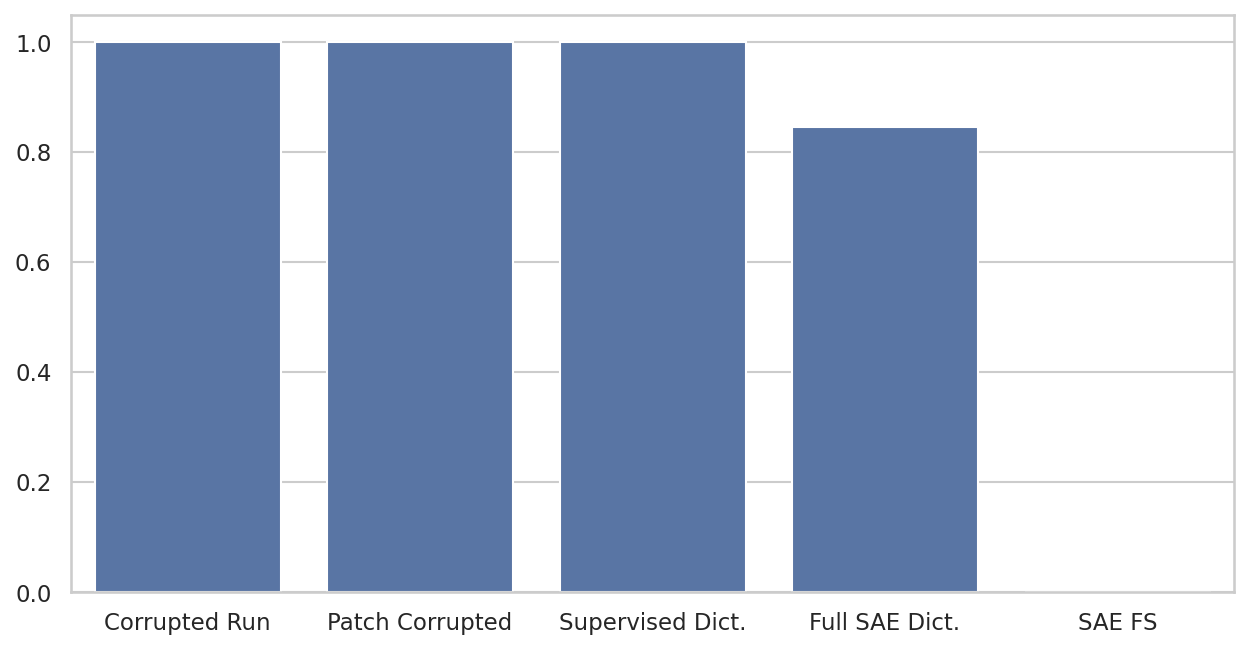

In [38]:
plt.figure(figsize=(10, 5), dpi=150)
sns.barplot((ldiff < 0).mean())